In [2]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import re
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import Add
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image as keras_image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.image as mpimg
from tqdm import tqdm

In [3]:
# Đường dẫn tới file CSV
csv_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Đọc file CSV
data = pd.read_csv(csv_path, delimiter='|', names=['image_name', 'comment_number', 'comment'], skiprows=1)
data['comment'] = data['comment'].fillna('')

# Làm sạch và chuẩn bị từ điển ảnh-mô tả
image_map = {}
def clean_text(sentence):
    sentence = sentence.lower()
    # Làm sạch câu
    cleaned = re.sub(r"[^a-zA-Z0-9.,\s]", "", sentence)
    # Tách câu thành danh sách từ
    words = cleaned.split()
    # Nếu câu mô tả có số từ lớn hơn 48 -> chỉ giữ lại 48 từ đầu tiên
    if len(words) > 48:
        cleaned = " ".join(words[:48])
    return cleaned

for _, row in data.iterrows():
    image_name = row['image_name'].strip()
    comment = row['comment'].strip()
    comment = clean_text(comment)
    comment = f"start {comment} end" 
    if image_name not in image_map:
        image_map[image_name] = []
    image_map[image_name].append(comment)
    
# Kiểm tra kết quả
print(f"Số lượng ảnh: {len(image_map)}")
for image, comments in list(image_map.items())[:3]:  # Hiển thị bình luận của 3 ảnh đầu tiên
    print(f"\nẢnh: {image}")
    print("Bình luận:")
    print(comments)

Số lượng ảnh: 31783

Ảnh: 1000092795.jpg
Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg
Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']

Ảnh: 1000268201.jpg
Bình luận:
['start a child in a pink dress is climbing up a set of stairs in an entry way . end', 'start a little girl in a pink dress going into a wooden cabin . end', 'start a little girl climbing the stairs to her playhouse . end', 'start a little girl c


Ảnh: 1000092795.jpg


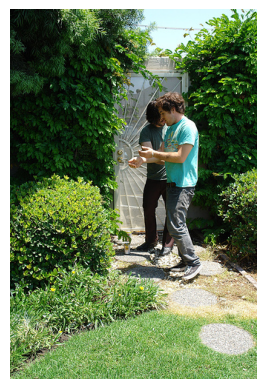

Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg


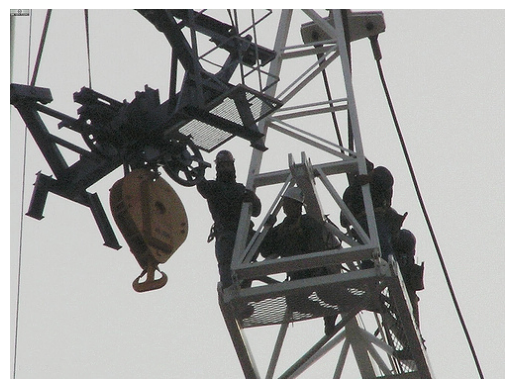

Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']


In [4]:
# Đường dẫn thư mục chứa ảnh
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
# Hiển thị ảnh từ image_map
for image_name, comments in list(image_map.items())[:2]:  # Hiển thị 2 ảnh đầu tiên
    # Tạo đường dẫn đầy đủ đến ảnh
    image_path = image_dir + image_name
    print(f"\nẢnh: {image_name}")
    
    # Đọc và hiển thị ảnh
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    
    print("Bình luận:")
    print(comments)

In [5]:
# Chia tập train, val, test
total_images = len(image_map)
val_size = int(total_images * 0.2)
test_size = int(total_images * 0.01)
train_size = total_images - val_size - test_size

sorted_image_names = sorted(image_map.keys())
train_images = sorted_image_names[:train_size]
val_images = sorted_image_names[train_size:train_size + val_size]
test_images = sorted_image_names[train_size + val_size:]

train_map = {img: image_map[img] for img in train_images}
val_map = {img: image_map[img] for img in val_images}
test_map = {img: image_map[img] for img in test_images}

print(f"Tập train: {len(train_map)} ảnh")
print(f"Tập val: {len(val_map)} ảnh")
print(f"Tập test: {len(test_map)} ảnh")

Tập train: 25110 ảnh
Tập val: 6356 ảnh
Tập test: 317 ảnh


In [6]:
# Load mô hình Inception v3
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)  # Loại bỏ layer cuối

# Hàm tiền xử lý hình ảnh
def preprocess_batch(image_paths):
    images = []
    for img_path in image_paths:
        img = keras_image.load_img(img_path, target_size=(299, 299))  # Đổi lại ở đây
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        images.append(x)
    return np.vstack(images)

# Hàm encode batch hình ảnh
def encode_batch(image_paths, model):
    preprocessed_images = preprocess_batch(image_paths)
    features = model.predict(preprocessed_images, verbose=0)
    features = np.reshape(features, (features.shape[0], -1))  # Reshape thành (batch_size, 2048)
    return features

batch_size = 128
# Encode training set
print("Encoding training images...")
encoding_image_train = {}
image_paths_train = [image_dir + str(img) for img in train_map.keys()]
for i in tqdm(range(0, len(image_paths_train), batch_size), desc="Processing Train"):
    batch_paths = image_paths_train[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_new)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_train[img_name] = batch_features[j]

# Encode validation set
print("Encoding validation images...")
encoding_image_val = {}
image_paths_val = [image_dir + str(img) for img in val_map.keys()]
for i in tqdm(range(0, len(image_paths_val), batch_size), desc="Processing Validation"):
    batch_paths = image_paths_val[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_new)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_val[img_name] = batch_features[j]

# Encode test set
print("Encoding test images...")
encoding_image_test = {}
image_paths_test = [image_dir + str(img) for img in test_map.keys()]
for i in tqdm(range(0, len(image_paths_test), batch_size), desc="Processing Test"):
    batch_paths = image_paths_test[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_new)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_test[img_name] = batch_features[j]

print("Encoding completed for train, validation, and test sets!")

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Encoding training images...


Processing Train:   0%|          | 0/197 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1734596651.911648      67 service.cc:145] XLA service 0x799040003f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734596651.911701      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734596660.151349      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Train: 100%|██████████| 197/197 [08:44<00:00,  2.66s/it]


Encoding validation images...


Processing Validation: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Encoding test images...


Processing Test: 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

Encoding completed for train, validation, and test sets!


In [7]:
print("Ví dụ Ecoding cho 1 ảnh Train: ",list(encoding_image_train.keys())[0])
print(list(encoding_image_train.values())[2])

print("Ví dụ Ecoding cho 1 ảnh Test:",list(encoding_image_val.keys())[0])
print(list(encoding_image_val.values())[2])

# Đường dẫn thư mục
pickle_dir = "/kaggle/working/Pickle"

# Kiểm tra và tạo thư mục nếu chưa tồn tại
os.makedirs(pickle_dir, exist_ok=True)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_train_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_train, encoded_pickle)
    
# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_val_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_val, encoded_pickle)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_test_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_test, encoded_pickle)

model_new.save('/kaggle/working/inception_v3_feature_extractor.h5')

Ví dụ Ecoding cho 1 ảnh Train:  1000092795.jpg
[0.12274794 0.3329202  0.75267315 ... 0.21935898 0.3020327  0.40283298]
Ví dụ Ecoding cho 1 ảnh Test: 4922678481.jpg
[1.067312   0.01315474 0.7696135  ... 0.4595397  0.23770292 0.13322857]


In [8]:
train_features = load(open("/kaggle/working/Pickle/encoded_train_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh train = %d\n' % len(train_features))
test_features = load(open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh train = %d\n' % len(test_features))
# Tạo list các training caption
all_train_captions = []  
for key, val in train_map.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
print("5 mô tả đầu tiên của tất cả mô tả: ",all_train_captions[:5])
# Chỉ lấy các từ xuất hiện trên 3 lần
word_count_threshold = 3
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('\nXử lý từ %d từ vựng -> xuống còn %d từ vựng\n' % (len(word_counts), len(vocab)))
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
# print("Danh sách từ điển từ: ",wordtoix)
# print("Từ điển từ",ixtoword) 
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
print("\nVocab_size= ",vocab_size)

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_map)
print('\nĐộ dài lớn nhất của một mô tả: %d' % max_length)

Số lượng vecto encoding ảnh train = 25110

Số lượng vecto encoding ảnh train = 317

5 mô tả đầu tiên của tất cả mô tả:  ['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Xử lý từ 17614 từ vựng -> xuống còn 8787 từ vựng


Vocab_size=  8788

Độ dài lớn nhất của một mô tả: 50


In [9]:
import pickle

# Lưu từ điển wordtoix vào file
with open('/kaggle/working/Pickle/wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

# Lưu từ điển ixtoword vào file
with open('/kaggle/working/Pickle/ixtoword.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

print("Đã lưu thành công wordtoix và ixtoword.")


Đã lưu thành công wordtoix và ixtoword.


In [10]:
# Load Glove model
glove_dir = '/kaggle/input/glove6b'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']

embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():  # duyệt trong từ điển từ
    #if i < max_words:
    embedding_vector = embeddings_index.get(word) # embecdding cho từ đó 
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print("\nCấu hình của ma trận vecto embedding cho từ điển từ:",embedding_matrix.shape)

print('\nVí dụ từ thứ nhất: ',list(wordtoix.keys())[1])
print('Ma trận embedding: ',embedding_matrix[1])

print('\nVí dụ từ thứ hai: ',list(wordtoix.keys())[2])
print('Ma trận embedding: ',embedding_matrix[2])

Found 400000 word vectors.

Cấu hình của ma trận vecto embedding cho từ điển từ: (8788, 300)

Ví dụ từ thứ nhất:  two
Ma trận embedding:  [ 2.54000008e-01  3.01470011e-01  1.42729998e-01  1.68789998e-01
  4.95770015e-02  1.94069996e-01 -3.56959999e-01  2.77420014e-01
  3.53549987e-01 -1.32350004e+00  7.96609968e-02  1.06349997e-01
 -6.84290007e-02 -2.22750008e-02 -2.42219999e-01  9.01470035e-02
  2.87169993e-01 -7.86150023e-02  3.81999999e-01  2.24509999e-01
 -1.58999994e-01 -1.07210003e-01  9.39219967e-02 -5.56450002e-02
  2.57739991e-01 -3.48210007e-01  4.38910007e-01 -4.19409990e-01
 -1.43240005e-01  2.71429997e-02  5.18609993e-02  1.58280000e-01
  2.58929998e-01  2.96149999e-02 -1.53419995e+00  2.92149991e-01
 -5.45400023e-01  1.36649996e-01 -5.60869984e-02  5.29070012e-02
  1.29950002e-01  9.77459997e-02 -5.33079989e-02 -1.44529998e-01
 -1.74860001e-01 -2.62050003e-01  2.13550008e-03  4.98659998e-01
 -7.20610023e-02 -1.20499998e-01  5.33169985e-01 -1.43069997e-01
 -1.58069998e-01 

In [11]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == num_photos_per_batch:
                yield ((np.array(X1), np.array(X2)), np.array(y))  
                X1, X2, y = [], [], []
                n = 0

In [12]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid')(se2)
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.optimizer.lr = 0.0001
epochs = 2
number_pics_per_bath = 16
steps = len(train_map)//number_pics_per_bath

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Track accuracy as well
)

# Number of epochs and batch size
epochs = 30
number_pics_per_batch = 16
steps_train = len(train_map) // number_pics_per_batch
steps_val = len(val_map) // number_pics_per_batch

# Create generators for train and validation datasets
train_generator = data_generator(train_map, train_features, wordtoix, max_length, number_pics_per_batch)
val_generator = data_generator(val_map, encoding_image_val, wordtoix, max_length, number_pics_per_batch)

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights
)

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.keras',  # Path to save the best model
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,       # Save only when val_loss improves
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_train,
    validation_data=val_generator,
    validation_steps=steps_val,
    verbose=1,
    callbacks=[early_stopping, checkpoint]  # Add callbacks to the training process
)

# Extract loss values for each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list to store training and validation loss over epochs
loss_progress = []

# Print detailed results after each epoch
print("\nTraining Results:")
for i in range(len(train_loss)):  # Loop through completed epochs
    epoch_data = {
        "epoch": i + 1,
        "train_loss": train_loss[i],
        "val_loss": val_loss[i]
    }
    loss_progress.append(epoch_data)
    print(f"Epoch {i+1}:")
    print(f"  Train Loss: {train_loss[i]:.4f}")
    print(f"  Val Loss:   {val_loss[i]:.4f}")

# Notify when training is complete
print("\nTraining process completed.")


Epoch 1/30
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2068 - loss: 5.3375
Epoch 1: val_loss improved from inf to 4.23479, saving model to /kaggle/working/best_model.keras
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 331s 209ms/step - accuracy: 0.2068 - loss: 5.3370 - val_accuracy: 0.2937 - val_loss: 4.2348
Epoch 2/30
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3246 - loss: 3.8985
Epoch 2: val_loss improved from 4.23479 to 3.85962, saving model to /kaggle/working/best_model.keras
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 328s 209ms/step - accuracy: 0.3246 - loss: 3.8984 - val_accuracy: 0.3217 - val_loss: 3.8596
Epoch 3/30
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3479 - loss: 3.5955
Epoch 3: val_loss improved from 3.85962 to 3.66476, saving model to /kaggle/working/best_model.keras
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 328s 209ms/step - accuracy: 0.3479 - loss: 3.5955 - val_accuracy: 0.3368 - val_loss: 3.6648
Epoch 4/30
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accu

In [14]:
model.save_weights('/kaggle/working/model_images_captioning.weights.h5')
model.save('/kaggle/working/model_images_captioning.h5')

In [15]:
images_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
with open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'start' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'end' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'start'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'end':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final
# def greedySearch(model, photo, wordtoix, max_length):
#     # Chuyển đổi ảnh thành batch nếu nó không phải là batch
#     if len(photo.shape) < 4:  # Nếu ảnh không phải là batch
#         photo = np.expand_dims(photo, axis=0)  # Thêm một chiều để tạo batch size = 1
    
#     # Tiến hành dự đoán
#     in_text = 'startseq'  # Dấu bắt đầu chuỗi
#     for _ in range(max_length):
#         sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
#         sequence = pad_sequences([sequence], maxlen=max_length)
        
#         # Dự đoán từ tiếp theo
#         yhat = model.predict([photo, sequence], verbose=0)
#         yhat = np.argmax(yhat)  # Lấy từ có xác suất cao nhất
#         word = ixtoword[yhat]  # Chuyển đổi từ chỉ số thành từ
        
#         in_text += ' ' + word
#         if word == 'endseq':  # Nếu gặp 'endseq', dừng lại
#             break
#     return in_text


    

ALL caption real:  ['start outdoor street view with a elementary schoolage boy in khaki pants and black tshirt standing on sidewalk next to a wall mural while an adult stoops over an individual sitting on the curb . end', 'start a young boy in a black teeshirt stands on the corner as two men parallel to him are engaged in some activity . end', 'start a young boy standing on the sidewalk while a man lifts up a bag in the background . end', 'start a boy standing next to a wall , while two men are bent over next to the street . end', 'start a little boy is eating on a sidewalk . end']
92497263.jpg
[0.4337017  0.19520628 0.7441616  ... 1.035953   0.35377032 0.476612  ]


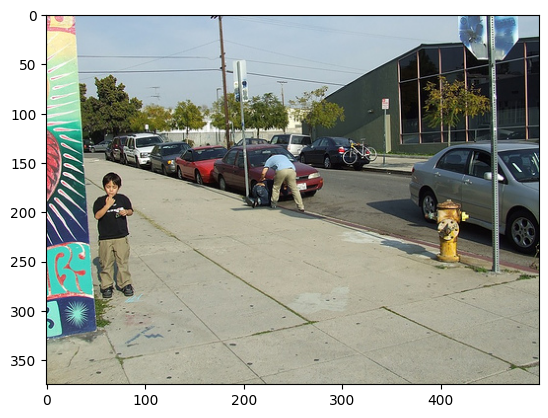

Caption:  a man in a blue shirt is walking down the street .


In [16]:
# Chọn ảnh từ encoding_test với chỉ số z
z = 120
pic = list(encoding_test.keys())[z]
cation_real=list(test_map.values())[z]
print("ALL caption real: ",cation_real)
print(pic)
print(encoding_test[pic])
# Trích xuất đặc trưng của ảnh từ encoding_test và chuẩn hóa lại kích thước
image = encoding_test[pic].reshape((1, 2048))

# Đọc và hiển thị ảnh
x = plt.imread(images_dir + pic)
plt.imshow(x)
plt.show()

# Gọi hàm greedySearch để tạo chuỗi mô tả cho ảnh
caption = greedySearch(image)
print("Caption: ", caption)

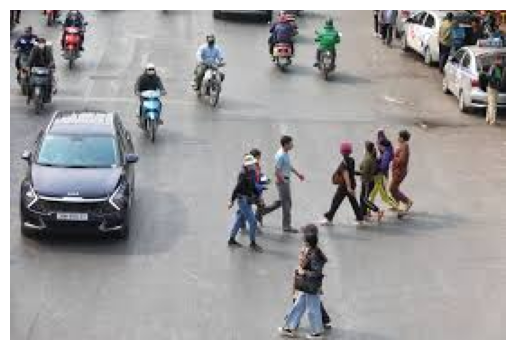

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Caption dự đoán:  a group of people are walking down the street .


In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load mô hình InceptionV3 để trích xuất đặc trưng
inception_model = InceptionV3(weights='imagenet')
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)

# Load model đã huấn luyện và từ điển wordtoix, ixtoword
model_path = '/kaggle/working/model_images_captioning.h5'
model = load_model(model_path)

with open('/kaggle/working/Pickle/wordtoix.pkl', 'rb') as f:
    wordtoix = pickle.load(f)

with open('/kaggle/working/Pickle/ixtoword.pkl', 'rb') as f:
    ixtoword = pickle.load(f)

# Hàm tiền xử lý và trích xuất đặc trưng từ ảnh
def extract_features(img_path, model):
    img = keras_image.load_img(img_path, target_size=(299, 299))  # Resize ảnh
    img_data = keras_image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)  # Tiền xử lý ảnh cho InceptionV3
    features = model.predict(img_data)
    return features

# Hàm greedySearch để tạo caption từ ảnh
def generate_caption(image_path):
    # Trích xuất đặc trưng ảnh
    photo = extract_features(image_path, feature_extractor)
    photo = photo.reshape((1, 2048))

    # Tạo caption
    in_text = 'start'
    for _ in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword.get(yhat, "")
        in_text += ' ' + word
        if word == 'end':
            break
    final_caption = ' '.join(in_text.split()[1:-1])  # Loại bỏ 'start' và 'end'
    return final_caption

# Hàm hiển thị ảnh và caption dự đoán
def predict_image_caption(image_path):
    # Hiển thị ảnh
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Dự đoán caption
    caption = generate_caption(image_path)
    print("Caption dự đoán: ", caption)

# Ví dụ sử dụng
image_path = '/kaggle/input/test-data/test_imagecaptioning.jpg'  # Đường dẫn ảnh bất kỳ
predict_image_caption(image_path)

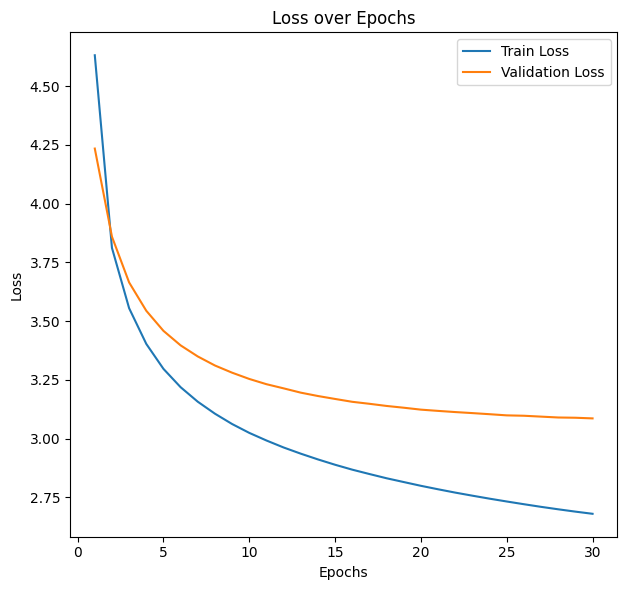

In [18]:
# Sau khi huấn luyện mô hình, lấy giá trị từ lịch sử huấn luyện
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))

# Vẽ train loss và validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ Accuracy
#plt.subplot(1, 2, 2)
#plt.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
#plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
#plt.title('Accuracy over Epochs')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [19]:
pip install nltk


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


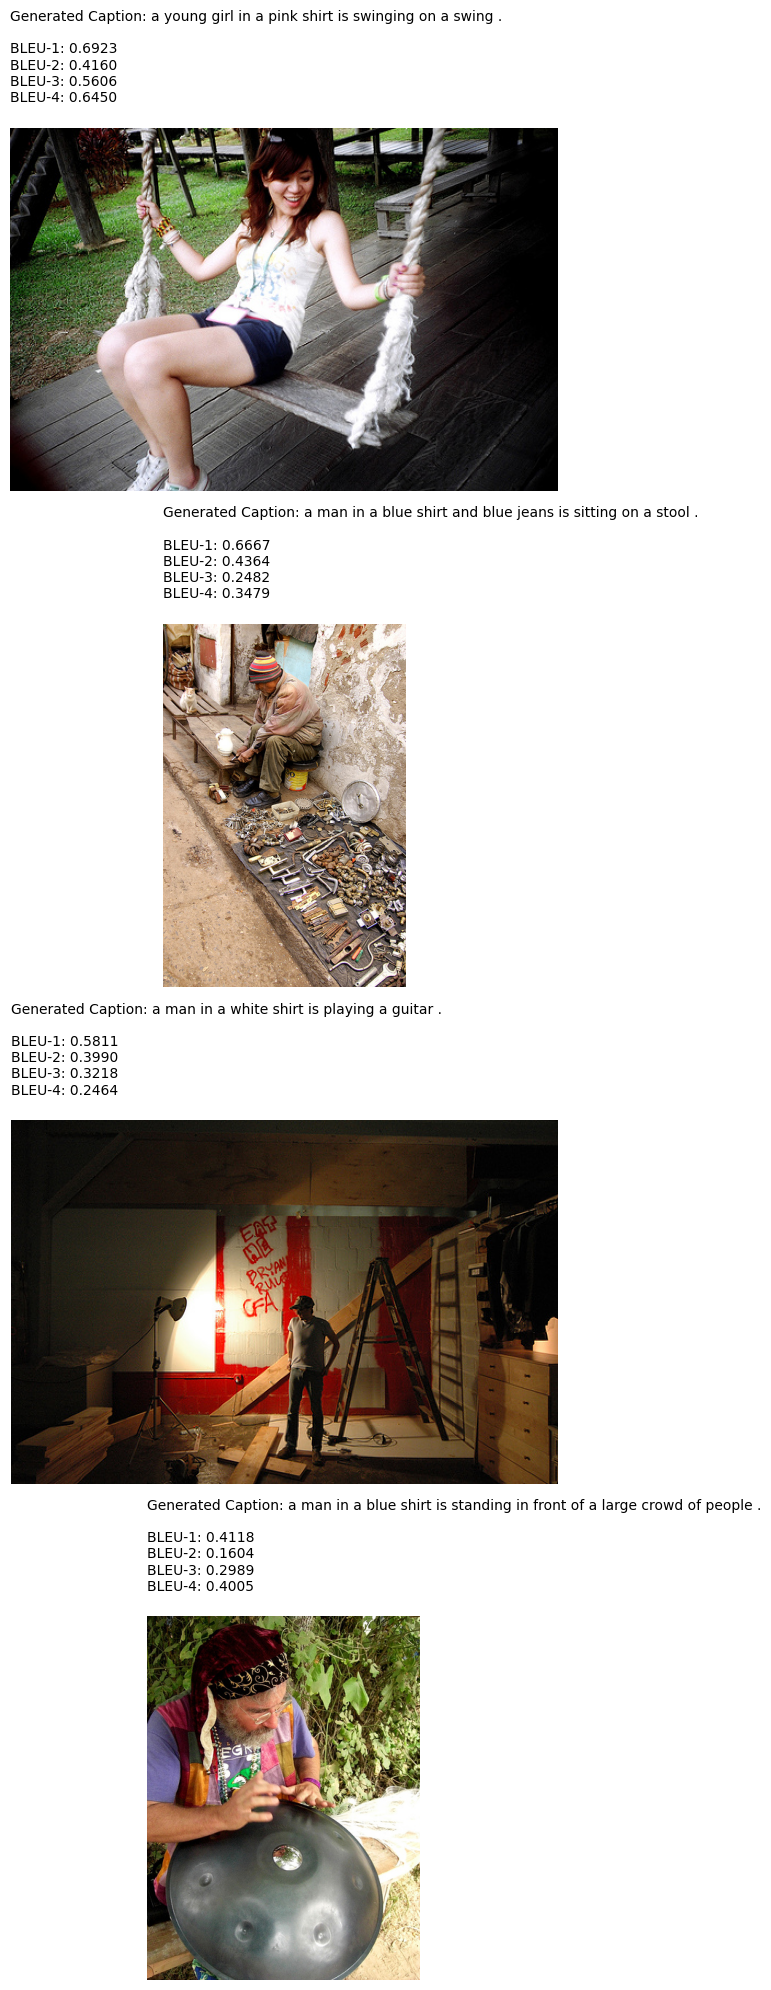


Image 1 (868984478.jpg) reference captions:
Reference 1: a young woman wearing shorts and a tank top is sitting on an outdoor swing .
Reference 2: happily , a young woman tries out her new oversized rope swing .
Reference 3: a young smiling woman is having fun on a rustic looking swing .
Reference 4: a young woman on a rope and plank swing in an outdoor setting .
Reference 5: a happy girl swings on her porch .
--------------------------------------------------------------------------------

Image 2 (86901941.jpg) reference captions:
Reference 1: this gentleman is working at his bench with the comfort of his cat nearby and a thermos at the ready .
Reference 2: a man with a colorful hat is sitting next to a variety of tools .
Reference 3: a old man sells hardware parts on a dirty sidewalk .
Reference 4: a man is sitting against a building using tools .
Reference 5: man sitting on a can in the street .
--------------------------------------------------------------------------------

Imag

In [20]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def display_images_with_captions_and_bleu(test_map, encoding_test, model, wordtoix, ixtoword, max_length, num_images=4):
    """
    Display images with generated captions and BLEU scores
    """
    # Get a sample of images from test set
    sample_images = list(test_map.items())[:num_images]
    
    plt.figure(figsize=(15, 5*num_images))
    
    for idx, (img_name, references) in enumerate(sample_images):
        # Generate caption
        photo = encoding_test[img_name].reshape((1, 2048))
        in_text = 'start'
        for i in range(max_length):
            sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = ixtoword.get(yhat, '')
            if word == '':
                break
            in_text += ' ' + word
            if word == 'end':
                break
        
        # Clean generated caption
        generated = in_text.split()[1:-1]  # Remove 'start' and 'end'
        generated_text = ' '.join(generated)
        
        # Clean reference captions
        cleaned_references = []
        for ref in references:
            # Remove 'start' and 'end' and tokenize
            cleaned_ref = ref.split()[1:-1]
            cleaned_references.append(cleaned_ref)
        
        # Calculate BLEU scores
        bleu1 = sentence_bleu(cleaned_references, generated, weights=(1.0, 0, 0, 0))
        bleu2 = sentence_bleu(cleaned_references, generated, weights=(0.5, 0.5, 0, 0))
        bleu3 = sentence_bleu(cleaned_references, generated, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = sentence_bleu(cleaned_references, generated, weights=(0.25, 0.25, 0.25, 0.25))
        
        # Display image and scores
        plt.subplot(num_images, 1, idx+1)
        img = plt.imread(os.path.join(image_dir, img_name))
        plt.imshow(img)
        plt.axis('off')
        
        # Create caption text with BLEU scores
        caption_text = f"Generated Caption: {generated_text}\n\n"
        caption_text += f"BLEU-1: {bleu1:.4f}\n"
        caption_text += f"BLEU-2: {bleu2:.4f}\n"
        caption_text += f"BLEU-3: {bleu3:.4f}\n"
        caption_text += f"BLEU-4: {bleu4:.4f}"
        
        plt.title(caption_text, loc='left', pad=20, fontsize=10, wrap=True)
    
    plt.tight_layout()
    plt.show()

# Example usage
display_images_with_captions_and_bleu(
    test_map,
    encoding_test,
    model,
    wordtoix,
    ixtoword,
    max_length,
    num_images=4
)

# To also see the reference captions for comparison
def print_reference_captions(test_map, num_images=4):
    """
    Print reference captions for the sample images
    """
    sample_images = list(test_map.items())[:num_images]
    
    for idx, (img_name, references) in enumerate(sample_images):
        print(f"\nImage {idx+1} ({img_name}) reference captions:")
        for i, ref in enumerate(references):
            # Remove 'start' and 'end' tokens
            clean_ref = ' '.join(ref.split()[1:-1])
            print(f"Reference {i+1}: {clean_ref}")
        print("-" * 80)

print_reference_captions(test_map)

Generating captions and calculating BLEU scores...


100%|██████████| 317/317 [04:20<00:00,  1.22it/s]



Calculating BLEU scores...

BLEU Scores for Test Set:
BLEU-1: 0.6054
BLEU-2: 0.3916
BLEU-3: 0.2586
BLEU-4: 0.1704
Average BLEU Score: 0.3565


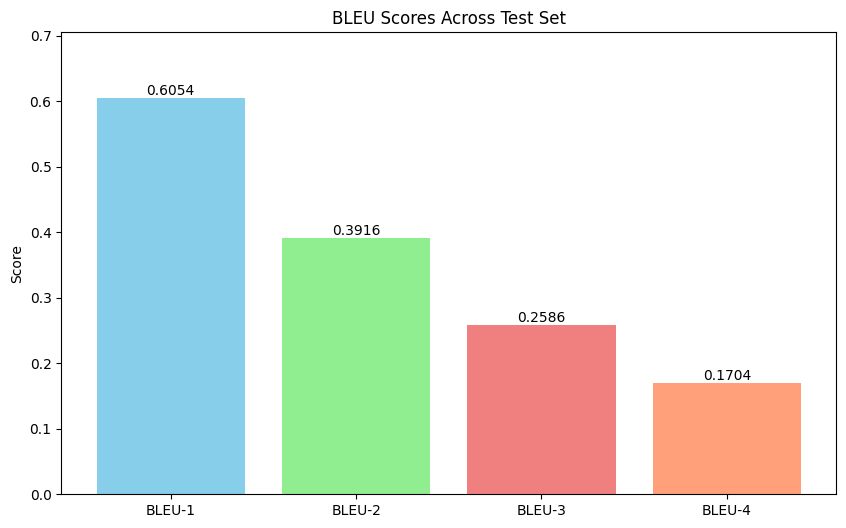

In [21]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def calculate_average_bleu(test_map, encoding_test, model, wordtoix, ixtoword, max_length):
    """
    Calculate average BLEU scores across the entire test set
    """
    # Lists to store all references and hypotheses
    all_references = []
    all_hypotheses = []
    
    # Initialize smoothing function for BLEU calculation
    smoother = SmoothingFunction()
    
    print("Generating captions and calculating BLEU scores...")
    # Process each image in the test set
    for img_name, references in tqdm(test_map.items()):
        # Get image features
        photo = encoding_test[img_name].reshape((1, 2048))
        
        # Generate caption
        in_text = 'start'
        predicted_words = []
        
        # Generate caption word by word
        for i in range(max_length):
            sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = ixtoword.get(yhat, '')
            if word == '' or word == 'end':
                break
            predicted_words.append(word)
            in_text += ' ' + word
        
        # Process reference captions
        cleaned_references = []
        for ref in references:
            # Remove 'start' and 'end' tokens and split into words
            cleaned_ref = ref.split()[1:-1]
            cleaned_references.append(cleaned_ref)
        
        # Add to collection
        all_references.append(cleaned_references)
        all_hypotheses.append(predicted_words)
    
    # Calculate BLEU scores
    bleu_scores = []
    weights_list = [
        (1.0, 0, 0, 0),      # BLEU-1
        (0.5, 0.5, 0, 0),    # BLEU-2
        (0.33, 0.33, 0.33, 0), # BLEU-3
        (0.25, 0.25, 0.25, 0.25) # BLEU-4
    ]
    
    print("\nCalculating BLEU scores...")
    for weights in weights_list:
        score = corpus_bleu(
            all_references, 
            all_hypotheses,
            weights=weights,
            smoothing_function=smoother.method1
        )
        bleu_scores.append(score)
    
    # Calculate average BLEU score
    avg_bleu = np.mean(bleu_scores)
    
    # Print results
    print('\nBLEU Scores for Test Set:')
    print(f'BLEU-1: {bleu_scores[0]:.4f}')
    print(f'BLEU-2: {bleu_scores[1]:.4f}')
    print(f'BLEU-3: {bleu_scores[2]:.4f}')
    print(f'BLEU-4: {bleu_scores[3]:.4f}')
    print(f'Average BLEU Score: {avg_bleu:.4f}')
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], 
        bleu_scores,
        color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    )
    
    plt.title('BLEU Scores Across Test Set')
    plt.ylabel('Score')
    plt.ylim(0, max(bleu_scores) + 0.1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )
    
    plt.show()
    
    return bleu_scores, avg_bleu, all_references, all_hypotheses

# Usage example
bleu_scores, avg_bleu, references, hypotheses = calculate_average_bleu(
    test_map,
    encoding_test,
    model,
    wordtoix,
    ixtoword,
    max_length
)